# Import

In [1]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
#from algae_core import cmap
import pickle
import os, fnmatch

#lbp
radius = 3
cmax=640
rmax=480
hws=3
def get_image_pair(file_pair):
    """ """
    oim=cv2.imread(file_pair['raw'])#BGR
    im=cv2.resize(oim, (cmax,rmax),interpolation = cv2.INTER_CUBIC) 
       
    ocl=cv2.imread(file_pair['label'],0)
    cl=cv2.resize(ocl, (cmax,rmax),interpolation = cv2.INTER_NEAREST )
    #print cl.shape
    if cl is None:# not found
         cl=np.zeros( (im.shape[0],im.shape[1]),dtype=np.uint8 )
    
    print "raw: %s, label: %s"%(file_pair['raw'], file_pair['label'])
    
    im_grey=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern( im_grey, 8 * radius, radius, 'uniform')
    #cv2.imshow("lbp", lbp)
    return cl,im,lbp

def show_overlay(cl,im):
    ol=im.copy() 
    for r in xrange(rmax):
        for c in xrange(cmax):
            if cl[r,c]:
                ol[r,c] = cmap[cl[r,c]-1]
    cv2.imshow("overlay", ol)

def get_xy(train_pairs):
    xrmax= ( (rmax-2*hws)*(cmax-2*hws)*len(train_pairs) )
    xcmax= 3+(2*hws)**2    
    x=np.zeros((xrmax,xcmax), dtype=np.uint8)
    
    yrmax= ( (rmax-2*hws)*(cmax-2*hws)*len(train_pairs) )
    y=np.zeros((yrmax), dtype=np.uint8)
    k=0
    for count,i in enumerate(train_pairs):    
        #print "------- processed %d from %d"%(count,len(train_pairs))
        cl,im,lbp=get_image_pair(i)
        #show_overlay(cl,im)
        if im.shape[0]!=rmax or im.shape[1]!=cmax or lbp.shape[0]!=rmax or lbp.shape[1]!=cmax:
            print "Error: image pair has missmatch size."
        for r in xrange(hws,lbp.shape[0]-hws):
            for c in xrange(hws,lbp.shape[1]-hws):
                xrow=np.concatenate([im[r,c],
                        lbp[r-hws:r+hws,c-hws:c+hws].reshape(1,-1)[0],])
                x[k,:]=xrow
                y[k]=cl[r,c]
                k+=1
    return x,y

def preprocess(dataset_path):
    raw_files=fnmatch.filter(os.listdir(dataset_path), '*.jpg')
    raw_list=[i[:-4] for i in raw_files]

    label_files=fnmatch.filter(os.listdir(dataset_path), '*.png')
    label_list={i[:-4]:None for i in label_files}

    train_pairs=[]
    for count,i in enumerate(raw_list):
        if i in label_list:
            train_pairs.append({
                'raw': os.path.join(dataset_path,i)+'.jpg',
                'label': os.path.join(dataset_path,i)+'.png',
            })

    with open(os.path.join(dataset_path,'train_pairs.obj'),'wb') as f:
        pickle.dump(train_pairs, f, pickle.HIGHEST_PROTOCOL)

    for e,i in enumerate(train_pairs):
        x,y = get_xy([i])
        with open(os.path.join(dataset_path,'%03d.xy'%e),'wb') as f:
            pickle.dump({'x':x, 'y':y }, f, pickle.HIGHEST_PROTOCOL)

# 1. Prepare

In [ ]:
## loading xy
import numpy as np
import pickle
import os
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from datetime import datetime
from sklearn.utils import shuffle

dataset_path=os.path.join('storage','training')
preprocess(dataset_path)

xy_files=fnmatch.filter(os.listdir(dataset_path), '*.xy')
xlist=[]
ylist=[]
for i in xy_files:
    with open(os.path.join(dataset_path,i),'rb') as f:
        xy = pickle.load(f)
        xlist.append( xy['x'] )
        ylist.append( xy['y'] )
        
x=np.concatenate(xlist, axis=0)
y=np.concatenate(ylist)

x, y = shuffle(x, y, random_state=datetime.now().second)

print "x.shape: %s, y.shape: %s"%(x.shape, y.shape)

raw: storage\training\[160125_214715]_100.jpg, label: storage\training\[160125_214715]_100.png
raw: storage\training\[160125_214715]_102.jpg, label: storage\training\[160125_214715]_102.png
raw: storage\training\[160125_214715]_103.jpg, label: storage\training\[160125_214715]_103.png
raw: storage\training\[160125_214715]_104.jpg, label: storage\training\[160125_214715]_104.png
raw: storage\training\[160125_214715]_105.jpg, label: storage\training\[160125_214715]_105.png
raw: storage\training\[160125_214715]_106.jpg, label: storage\training\[160125_214715]_106.png
raw: storage\training\[160125_214715]_107.jpg, label: storage\training\[160125_214715]_107.png
raw: storage\training\[160125_214715]_108.jpg, label: storage\training\[160125_214715]_108.png
raw: storage\training\[160125_214715]_109.jpg, label: storage\training\[160125_214715]_109.png
raw: storage\training\[160125_214715]_110.jpg, label: storage\training\[160125_214715]_110.png
raw: storage\training\[160125_214715]_114.jpg, lab

# 2. Train

In [3]:
clf_et = ExtraTreesClassifier(n_estimators=1, max_depth=30, n_jobs=-1,
    min_samples_split=1, random_state=datetime.now().second, 
    max_features=None, verbose=True)

#scores = cross_val_score(clf_et, x, y, cv=5)
#print scores
#print "--Extra Tree: %s"%scores.mean()

print "--Training"
t=clf_et.fit( x, y)
fname=datetime.now().strftime("%m%d%H%M%S")+'.tree'
with open(os.path.join(dataset_path,fname),'wb') as f:
    pickle.dump(t,f, pickle.HIGHEST_PROTOCOL)

print '--Finished'

--Training
--Finished


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished


# 3. Combine tree

In [8]:
import os, fnmatch
import pickle

dataset_path=os.path.join('storage','training')
def combine_trees(et_a, et_b):
    et_a.estimators_ += et_b.estimators_
    et_a.n_estimators = len(et_a.estimators_)
    return et_a

t_list=fnmatch.filter(os.listdir(dataset_path), '*.tree')
tree_list=[]
for i in t_list:
    with open(os.path.join(dataset_path, i ),'rb') as f:
        tree_list.append(pickle.load(f))
forest = reduce(combine_trees, tree_list)
with open(os.path.join(dataset_path,'forest.pic'),'wb') as f:
    pickle.dump(forest,f, pickle.HIGHEST_PROTOCOL)
    
print "combining %s"%t_list
print "to generate %s"%fnmatch.filter(os.listdir(dataset_path), '*.pic')

combining ['1102004136.tree']
to generate ['forest.pic']


# 4. Predict

In [9]:
%matplotlib inline
import numpy as np
import os
from matplotlib import pyplot as plt
import pickle

dataset_path=os.path.join('storage','training')
with open(os.path.join(dataset_path,'forest.pic'),'rb') as f:
    forest = pickle.load(f)
    
dataset_path=os.path.join('storage','evaluation')
preprocess(dataset_path)

cmap=np.array([  
    ( 0  , 255, 255,  ),
    ( 14 , 127, 255,  ),
    ( 44 , 160, 44 ,  ),
    ( 40 , 39 , 214,  ),
    ( 0  , 0  , 255,  ),
    ( 0  , 255, 0  ,  ),
    ( 194, 119, 227,  ),
    ( 255, 0  , 0  ,  ),
    ( 34 , 189, 188,  ),
    ( 207, 190, 23 ,  ),])

with open(os.path.join(dataset_path,'train_pairs.obj'),'rb') as f:
    train_pairs = pickle.load(f)

#i=train_pairs[1]

raw: storage\evaluation\[160112_162212]_03.jpg, label: storage\evaluation\[160112_162212]_03.png
raw: storage\evaluation\[160112_162212]_08.jpg, label: storage\evaluation\[160112_162212]_08.png
raw: storage\evaluation\[160112_162212]_12.jpg, label: storage\evaluation\[160112_162212]_12.png
raw: storage\evaluation\[160112_162212]_17.jpg, label: storage\evaluation\[160112_162212]_17.png
raw: storage\evaluation\[160112_162212]_20.jpg, label: storage\evaluation\[160112_162212]_20.png
raw: storage\evaluation\[160112_162212]_23.jpg, label: storage\evaluation\[160112_162212]_23.png
raw: storage\evaluation\[160112_162212]_32.jpg, label: storage\evaluation\[160112_162212]_32.png
raw: storage\evaluation\[160112_165018]_03.jpg, label: storage\evaluation\[160112_165018]_03.png
raw: storage\evaluation\[160112_165018]_12.jpg, label: storage\evaluation\[160112_165018]_12.png
raw: storage\evaluation\[160112_165018]_20.jpg, label: storage\evaluation\[160112_165018]_20.png


raw: storage\evaluation\[160112_162212]_03.jpg, label: storage\evaluation\[160112_162212]_03.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


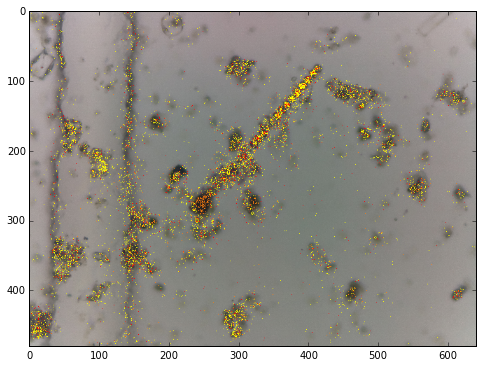

raw: storage\evaluation\[160112_162212]_08.jpg, label: storage\evaluation\[160112_162212]_08.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


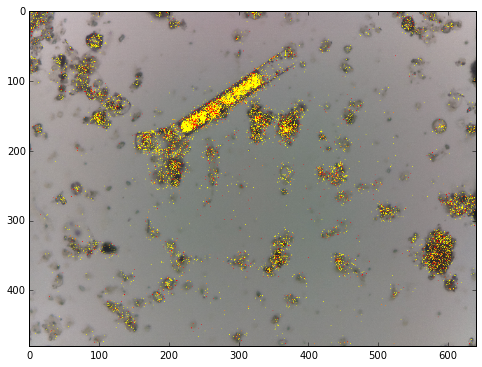

raw: storage\evaluation\[160112_162212]_12.jpg, label: storage\evaluation\[160112_162212]_12.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


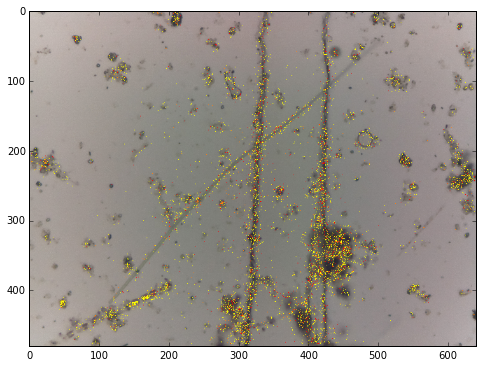

raw: storage\evaluation\[160112_162212]_17.jpg, label: storage\evaluation\[160112_162212]_17.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


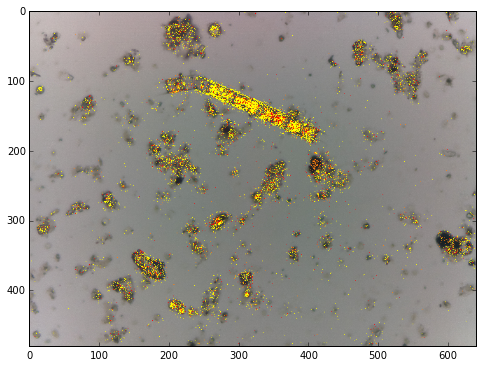

raw: storage\evaluation\[160112_162212]_20.jpg, label: storage\evaluation\[160112_162212]_20.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


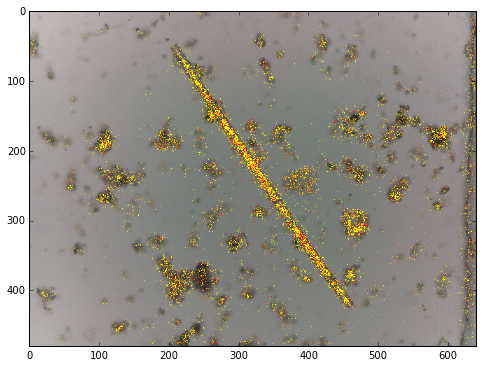

raw: storage\evaluation\[160112_162212]_23.jpg, label: storage\evaluation\[160112_162212]_23.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


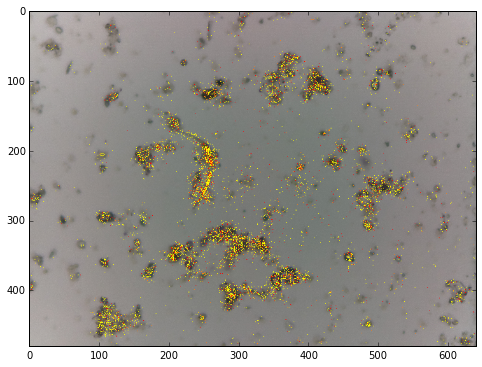

raw: storage\evaluation\[160112_162212]_32.jpg, label: storage\evaluation\[160112_162212]_32.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


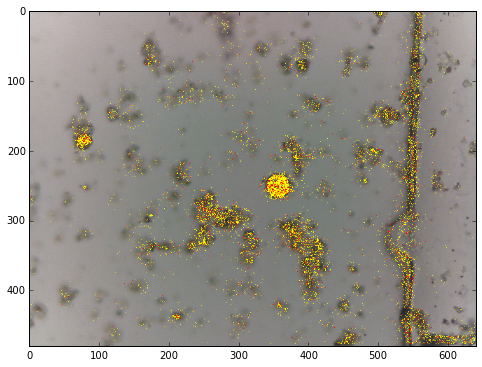

raw: storage\evaluation\[160112_165018]_03.jpg, label: storage\evaluation\[160112_165018]_03.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


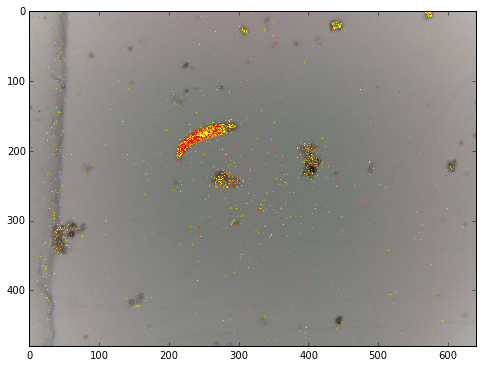

raw: storage\evaluation\[160112_165018]_12.jpg, label: storage\evaluation\[160112_165018]_12.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


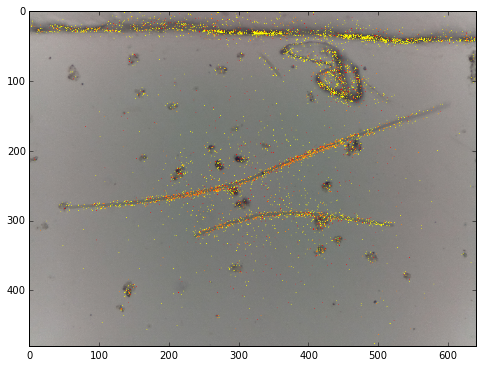

raw: storage\evaluation\[160112_165018]_20.jpg, label: storage\evaluation\[160112_165018]_20.png


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


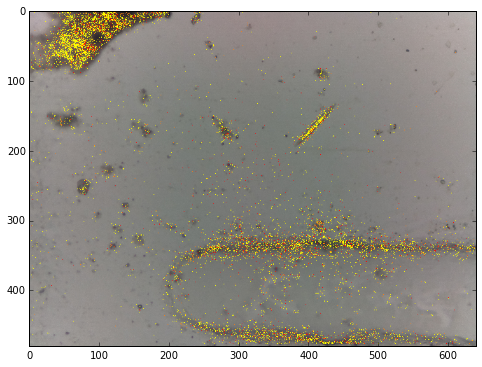

In [10]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)
for i in train_pairs:
    x,y=get_xy( [i] )
    oim=cv2.imread(i['raw'])#BGR
    im=cv2.resize(oim, (cmax,rmax),interpolation = cv2.INTER_CUBIC) 
    cl_p=forest.predict( x )
    cl_p.resize((rmax-2*hws,cmax-2*hws))
    ol=im.copy()
    for r in xrange(rmax-2*hws):
        for c in xrange(cmax-2*hws):
            predicting_class=cl_p[r,c]
            if predicting_class>0:
                ol[r+hws,c+hws] = cmap[ predicting_class-1 ]
    ol_rgb = cv2.cvtColor(ol, cv2.COLOR_BGR2RGB)
    plt.imshow(ol_rgb)
    plt.show()